In [18]:
# import mne

from pathlib import Path

import mne
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.dataset_utils import build_manifest_simple, save_manifest

## 0. Create manifest

In [66]:
DATASET_PATH = Path("C:/Users/MDBI/Documents/public-datasets/sleepy-rat/")

df = build_manifest_simple(DATASET_PATH)
save_manifest(df, DATASET_PATH / "manifest.csv")

In [67]:
df

,cohort,animal_id,edf_path,scoring_path,has_scoring
0,CohortA,A1,C:\Users\MDBI\Documents\public-datasets\sleepy...,C:\Users\MDBI\Documents\public-datasets\sleepy...,True
1,CohortA,A2,C:\Users\MDBI\Documents\public-datasets\sleepy...,C:\Users\MDBI\Documents\public-datasets\sleepy...,True
2,CohortA,A3,C:\Users\MDBI\Documents\public-datasets\sleepy...,C:\Users\MDBI\Documents\public-datasets\sleepy...,True
3,CohortA,A4,C:\Users\MDBI\Documents\public-datasets\sleepy...,C:\Users\MDBI\Documents\public-datasets\sleepy...,True
4,CohortB,B1,C:\Users\MDBI\Documents\public-datasets\sleepy...,C:\Users\MDBI\Documents\public-datasets\sleepy...,True
5,CohortB,B2,C:\Users\MDBI\Documents\public-datasets\sleepy...,C:\Users\MDBI\Documents\public-datasets\sleepy...,True
6,CohortB,B3,C:\Users\MDBI\Documents\public-datasets\sleepy...,C:\Users\MDBI\Documents\public-datasets\sleepy...,True
7,CohortB,B4,C:\Users\MDBI\Documents\public-datasets\sleepy...,C:\Users\MDBI\Documents\public-datasets\sleepy...,True
8,CohortC,C1,C:\Users\MDBI\Documents\public-datasets\sleepy...,C:\Users\MDBI\Documents\public-datasets\sleepy...,True
9,CohortC,C2,C:\Users\MDBI\Documents\public-datasets\sleepy...,C:\Users\MDBI\Documents\public-datasets\sleepy...,True


## 1. Load single EEG-recording

In [79]:
manifest = pd.read_csv("C:/Users/MDBI/Documents/public-datasets/sleepy-rat/manifest.csv")      # or use your in-memory df

row = manifest.iloc[0]
raw = mne.io.read_raw_edf(str(row['edf_path']), preload=True, stim_channel=None, verbose=False)
raw

<RawEDF | A1.edf, 3 x 11059200 (86400.0 s), ~253.1 MB, data loaded>

In [80]:
print(raw)                # basic info
print(raw.info["sfreq"])  # sampling rate (Hz)
print(raw.info["ch_names"])

<RawEDF | A1.edf, 3 x 11059200 (86400.0 s), ~253.1 MB, data loaded>
128.0
['EEG1', 'EEG2', 'EMG']


### Tell MNE what type of data is in each channel, is it EEG or EMG?

In [81]:
# Example mapping — adjust to your channel names:
mapping = {
    "EEG1": "eeg",     # or "EEG1"
    "EEG2": "eeg",
    "EMG": "emg"
}
present = {ch: tp for ch, tp in mapping.items() if ch in raw.ch_names}
if present:
    raw.set_channel_types(present)

raw

<RawEDF | A1.edf, 3 x 11059200 (86400.0 s), ~253.1 MB, data loaded>

### Load scorings

In [82]:
scorings = pd.read_csv(row['scoring_path'], index_col=0, names = ["score_1", "score_2"])

In [83]:
scorings

,score_1,score_2
0,n,n
1,n,n
2,n,n
3,n,n
4,n,n
...,...,...
10795,w,w
10796,w,w
10797,w,w
10798,w,w


## 2. Pre-processing steps for one EEG-recording

In [84]:
from pathlib import Path
import numpy as np
import pandas as pd
import mne

# ---------- load from your manifest ----------
row = manifest.iloc[0]                                
EDF_PATH = Path(row["edf_path"])
SCORING_CSV = Path(row["scoring_path"]) if pd.notna(row["scoring_path"]) else None


# ---------- parameters you can tweak ----------
EPOCH_LEN = 4.0         # mouse sleep scoring commonly 10 or 20 s; you have 20 s in many datasets
LINE_FREQ = 50.0         # set 60.0 if you're in a 60 Hz mains region
HP = 0.5                 # high-pass (Hz)
LP = 45.0                # low-pass (Hz); below hardware 64 Hz is fine
TARGET_SFREQ = 128.0     # you are already at 128 Hz; keep it consistent


# ---- 1) Load EDF header (lazy) ----
raw = mne.io.read_raw_edf(str(EDF_PATH), preload=False, stim_channel=None, verbose=False)

# Mark channel types (adjust names if yours differ)
eeg_like = [ch for ch in raw.ch_names if "EEG" in ch.upper()]
emg_like = [ch for ch in raw.ch_names if "EMG" in ch.upper()]
if eeg_like: raw.set_channel_types({ch: "eeg" for ch in eeg_like})
if emg_like: raw.set_channel_types({ch: "emg" for ch in emg_like})

# ---- 2) Read your scoring file (3 columns, no header) ----
# Accept comma OR semicolon just in case; strip spaces
sc = pd.read_csv(SCORING_CSV, header=None, names=["epoch", "score_1", "score_2"],
                 sep=r"[;,]", engine="python")
sc["score_1"] = sc["score_1"].astype(str).str.strip()
sc["score_2"] = sc["score_2"].astype(str).str.strip()

# Map label codes to canonical names
LABEL_MAP = {
    "w":"Wake", "wake":"Wake", "W":"Wake",
    "n":"NREM", "nr":"NREM", "N":"NREM", "NREM":"NREM",
    "r":"REM",  "rem":"REM", "R":"REM"
}

def norm_label(x: str) -> str:
    s = str(x).strip()
    return LABEL_MAP.get(s, LABEL_MAP.get(s.lower(), "Unknown"))

# Simple consensus between the two raters
PRIORITY = {"REM": 3, "NREM": 2, "Wake": 1, "Unknown": 0}
def consensus(a, b) -> str:
    a, b = norm_label(a), norm_label(b)
    if a == b: return a
    # tie-breaker: REM > NREM > Wake
    return a if PRIORITY[a] >= PRIORITY[b] else b

sc["stage"] = [consensus(a, b) for a, b in zip(sc["score_1"], sc["score_2"])]

# ---- 3) Turn rows into onsets/durations ----
rec_dur = float(raw.times[-1])                 # seconds
n_rows  = len(sc)
epoch_len = rec_dur / n_rows                   # ~4.0 s for your file
onsets   = np.arange(n_rows, dtype=float) * epoch_len
durations= np.full(n_rows, epoch_len, dtype=float)

# ---- 4) Attach annotations, crop to scored span, then load data ----
ann = mne.Annotations(onset=onsets, duration=durations,
                      description=sc["stage"].astype(str).to_numpy())
raw.set_annotations(ann)

raw.crop(tmin=float(onsets.min()), tmax=float(onsets.max() + epoch_len))
raw.load_data()

# ---- 5) Denoise (line + bands) ----
LINE = 50.0   # set to 60.0 if you're in a 60 Hz mains region
raw.notch_filter([LINE])

picks_eeg = mne.pick_types(raw.info, eeg=True,  emg=False)
picks_emg = mne.pick_types(raw.info, eeg=False, emg=True)

if len(picks_eeg):
    raw.filter(0.5, 45.0, picks=picks_eeg)   # EEG: sleep band
if len(picks_emg):
    raw.filter(10.0, 45.0, picks=picks_emg)  # EMG: keep activity band

# Optional average ref if ≥2 EEG
if len(picks_eeg) >= 2:
    raw.set_eeg_reference("average")

# ---- 6) Make per-epoch data (4 s) ----
event_id = {"Wake": 1, "NREM": 2, "REM": 3}
events = []
for onset, label in zip(onsets, sc["stage"]):
    if label not in event_id:    # skip Unknown
        continue
    events.append([int(round(onset * raw.info["sfreq"])), 0, event_id[label]])
events = np.asarray(events, dtype=int)

epochs4 = mne.Epochs(raw, events=events, event_id=event_id,
                     tmin=0.0, tmax=epoch_len, baseline=None,
                     preload=True, reject_by_annotation=True)

print(f"Epochs shape: {epochs4.get_data().shape}  (n_epochs, n_channels, n_times)")
# Optional: rebin to 20 s (group 5×4 s)
# ...

# ---- 7) Save outputs ----
raw.save("C:/Users/MDBI/Documents/public-datasets/sleepy-rat/processed-data/raw_preproc.fif", overwrite=True)
epochs4.save("C:/Users/MDBI/Documents/public-datasets/sleepy-rat/processed-data/epochs4s-epo.fif", overwrite=True)


Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.5

C:\Users\MDBI\AppData\Local\Temp\ipykernel_27960\1852924688.py:106: RuntimeWarning: This filename (C:\Users\MDBI\Documents\public-datasets\sleepy-rat\processed-data\raw_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save("C:/Users/MDBI/Documents/public-datasets/sleepy-rat/processed-data/raw_preproc.fif", overwrite=True)


Closing C:\Users\MDBI\Documents\public-datasets\sleepy-rat\processed-data\raw_preproc.fif
[done]
Overwriting existing file.
Overwriting existing file.


In [85]:
raw

<RawEDF | A1.edf, 3 x 11059200 (86400.0 s), ~253.1 MB, data loaded>

In [75]:
epochs4

<Epochs | 21597 events (all good), 0 – 4 s (baseline off), ~253.6 MB, data loaded,
 'Wake': 10564
 'NREM': 8539
 'REM': 2494>

In [76]:
import numpy as np
import pandas as pd
import mne

# Frequency bands (tweak if you like)
BANDS = {
    "delta": (0.5, 4.0),
    "theta": (6.0, 9.0),
    "sigma": (10.0, 15.0),
    "beta":  (15.0, 30.0),
}

def _integrate_band(psd, freqs, fmin, fmax):
    """Integrate power between fmin..fmax using the trapezoid rule."""
    idx = (freqs >= fmin) & (freqs < fmax)
    if not np.any(idx):
        return np.zeros(psd.shape[:-1])
    return np.trapz(psd[..., idx], freqs[idx], axis=-1)

def extract_epoch_features(epochs: mne.Epochs,
                           eeg_picks=None,
                           emg_pick=None,
                           bands=BANDS) -> tuple[pd.DataFrame, np.ndarray]:
    """
    Returns:
      - X: DataFrame (one row per epoch)
      - y: array of stage labels ('Wake','NREM','REM') from epochs.event_id
    """
    sfreq = epochs.info["sfreq"]

    # --- labels y from events ---
    inv_id = {v: k for k, v in epochs.event_id.items()}
    y = np.array([inv_id.get(code, "Unknown") for code in epochs.events[:, 2]])

    # --- choose channels ---
    if eeg_picks is None:
        eeg_picks = mne.pick_types(epochs.info, eeg=True, emg=False)
    if emg_pick is None:
        emg_candidates = mne.pick_types(epochs.info, eeg=False, emg=True)
        emg_pick = emg_candidates[0] if len(emg_candidates) else None

    # --- EEG PSD (Welch) ---
    # Using MNE's built-in welch on epochs; returns V^2/Hz
    psd = epochs.compute_psd(method="welch", fmin=0.5, fmax=45.0)
    freqs = psd.freqs
    psd_eeg = psd.get_data(picks=eeg_picks)  # (n_epochs, n_eeg, n_freqs)
    if psd_eeg.size == 0:
        raise RuntimeError("No EEG channels found. Check channel types.")
    psd_eeg_mean = psd_eeg.mean(axis=1)      # average across EEG channels → (n_epochs, n_freqs)

    # Total power in analysis band
    total = _integrate_band(psd_eeg_mean, freqs, 0.5, 45.0) + 1e-20  # +eps to avoid div/0

    # Bandpowers (absolute and relative)
    feats = {}
    for name, (f1, f2) in bands.items():
        bp = _integrate_band(psd_eeg_mean, freqs, f1, f2)           # V^2
        feats[f"{name}_abs"] = bp
        feats[f"{name}_rel"] = bp / total

    # Simple EEG ratios
    feats["theta_delta"] = feats["theta_abs"] / (feats["delta_abs"] + 1e-20)
    feats["sigma_delta"] = feats["sigma_abs"] / (feats["delta_abs"] + 1e-20)

    # --- EMG features (RMS) ---
    if emg_pick is not None:
        emg = epochs.get_data(picks=[emg_pick])[:, 0, :]  # (n_epochs, n_times)
        emg_rms_v = np.sqrt((emg ** 2).mean(axis=1))      # in Volts
        feats["emg_rms_uv"] = emg_rms_v * 1e6             # report in µV
        feats["emg_rms_log"] = np.log10(feats["emg_rms_uv"] + 1e-6)
    else:
        feats["emg_rms_uv"] = np.zeros(len(y))
        feats["emg_rms_log"] = np.zeros(len(y))

    # Assemble DataFrame
    X = pd.DataFrame(feats)
    return X, y


In [77]:
X_one, y_one = extract_epoch_features(epochs4)
X_one.head(), np.unique(y_one, return_counts=True)

Effective window size : 4.008 (s)


C:\Users\MDBI\AppData\Local\Temp\ipykernel_27960\1735457699.py:18: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[..., idx], freqs[idx], axis=-1)


(      delta_abs  delta_rel     theta_abs  theta_rel     sigma_abs  sigma_rel  \
 0  1.424768e-10   0.114969  2.160520e-10   0.174340  3.300775e-10   0.266351   
 1  2.720282e-10   0.180978  1.633843e-10   0.108698  3.307798e-10   0.220065   
 2  3.060551e-10   0.212357  2.520312e-10   0.174872  2.243878e-10   0.155692   
 3  3.448240e-10   0.139380  5.506970e-10   0.222595  5.821324e-10   0.235302   
 4  3.805450e-10   0.151019  5.054402e-10   0.200583  6.454865e-10   0.256161   
 
        beta_abs  beta_rel  theta_delta  sigma_delta  emg_rms_uv  emg_rms_log  
 0  2.114217e-10  0.170603     1.516402     2.316711   27.976080     1.446787  
 1  3.267474e-10  0.217383     0.600615     1.215976   22.469516     1.351594  
 2  2.326511e-10  0.161425     0.823483     0.733161   21.324376     1.328876  
 3  4.648554e-10  0.187898     1.597038     1.688202   24.588754     1.390737  
 4  2.697594e-10  0.107054     1.328201     1.696216   27.791812     1.443917  ,
 (array(['NREM', 'REM', 'Wake']

In [78]:
X_one

,delta_abs,delta_rel,theta_abs,theta_rel,sigma_abs,sigma_rel,beta_abs,beta_rel,theta_delta,sigma_delta,emg_rms_uv,emg_rms_log
0,1.424768e-10,0.114969,2.160520e-10,0.174340,3.300775e-10,0.266351,2.114217e-10,0.170603,1.516402,2.316711,27.976080,1.446787
1,2.720282e-10,0.180978,1.633843e-10,0.108698,3.307798e-10,0.220065,3.267474e-10,0.217383,0.600615,1.215976,22.469516,1.351594
2,3.060551e-10,0.212357,2.520312e-10,0.174872,2.243878e-10,0.155692,2.326511e-10,0.161425,0.823483,0.733161,21.324376,1.328876
3,3.448240e-10,0.139380,5.506970e-10,0.222595,5.821324e-10,0.235302,4.648554e-10,0.187898,1.597038,1.688202,24.588754,1.390737
4,3.805450e-10,0.151019,5.054402e-10,0.200583,6.454865e-10,0.256161,2.697594e-10,0.107054,1.328201,1.696216,27.791812,1.443917
...,...,...,...,...,...,...,...,...,...,...,...,...
21592,8.152086e-11,0.062781,4.328103e-10,0.333317,2.703968e-10,0.208239,2.150307e-10,0.165600,5.309197,3.316903,35.963510,1.555862
21593,1.207700e-10,0.113713,3.468966e-10,0.326628,2.133983e-10,0.200930,1.665801e-10,0.156847,2.872374,1.766981,44.334133,1.646738
21594,4.051657e-11,0.033221,1.032704e-10,0.084674,2.960185e-10,0.242713,2.103430e-10,0.172466,2.548844,7.306108,31.980311,1.504883
21595,2.919143e-10,0.175854,2.069523e-10,0.124672,3.903967e-10,0.235182,3.329385e-10,0.200568,0.708949,1.337368,34.064550,1.532303


## 3. Pre-process all data

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import mne

# Stage / artifact handling
STAGE_MAP = {"w":"Wake", "n":"NREM", "r":"REM", "W":"Wake", "N":"NREM", "R":"REM"}
ART = {"1","2","3"}
PRIORITY = {"REM": 3, "NREM": 2, "Wake": 1}


def norm_stage(x): return STAGE_MAP.get(str(x).strip(), "Unknown")
def is_artifact(a, b): return (str(a).strip() in ART) or (str(b).strip() in ART)
def consensus(a, b, consensus_rule="priority"):
    if is_artifact(a, b): return "Artifact"
    a, b = norm_stage(a), norm_stage(b)
    if consensus_rule == "agree": return a if a == b else "Unknown"
    if a == b: return a
    if a in PRIORITY and b in PRIORITY: return a if PRIORITY[a] >= PRIORITY[b] else b
    return "Unknown"

def preprocess_recording_to_epochs(
    edf_path: Path,
    scoring_csv: Path,
    *,
    epoch_len: float = 4.0,          # your epochs are 4 s
    line_freq: float = 50.0,         # set 60.0 if needed
    eeg_band: tuple = (0.5, 45.0),
    emg_band: tuple = (10.0, 45.0),
    consensus_rule: str = "priority" # "priority" or "agree"
):
    """Load EDF + 3-column scoring CSV (epoch_idx, score_1, score_2) and return clean 4-s epochs."""
    edf_path, scoring_csv = Path(edf_path), Path(scoring_csv)

    # 1) Raw (lazy) + channel types
    raw = mne.io.read_raw_edf(str(edf_path), preload=False, stim_channel=None, verbose=False)
    eeg_like = [ch for ch in raw.ch_names if "EEG" in ch.upper()]
    emg_like = [ch for ch in raw.ch_names if "EMG" in ch.upper()]
    if eeg_like: raw.set_channel_types({ch: "eeg" for ch in eeg_like})
    if emg_like: raw.set_channel_types({ch: "emg" for ch in emg_like})

    sfreq = float(raw.info["sfreq"])
    rec_end = float(raw.times[-1])           # last available time stamp (seconds)
    eps = 1.0 / sfreq * 1e-6                 # tiny epsilon in seconds (<< one sample)

    # 2) Read scoring (3 columns, no header)
    sc = pd.read_csv(scoring_csv, header=None, names=["epoch", "s1", "s2"], sep=r"[;,]", engine="python")
    sc["s1"] = sc["s1"].astype(str).str.strip()
    sc["s2"] = sc["s2"].astype(str).str.strip()

    # Stage / artifact handling
    sc["stage"] = [consensus(a, b, consensus_rule) for a, b in zip(sc["s1"], sc["s2"])]
    sc["artifact"] = [is_artifact(a, b) for a, b in zip(sc["s1"], sc["s2"])]

    # 3) Onsets/durations with safe clipping at file end
    n = len(sc)
    onsets = np.arange(n, dtype=float) * float(epoch_len)
    ends = onsets + float(epoch_len)

    # mask epochs that fully fit in the recording (strictly within rec_end - eps)
    full_fit = ends <= (rec_end - eps)

    # durations clipped for annotation safety (last one can be shorter)
    durations = np.minimum(float(epoch_len), np.maximum(0.0, rec_end - onsets))

    # 4) Build annotations with a consistent orig_time
    orig = raw.info.get("meas_date", None)
    ann_stage = mne.Annotations(onset=onsets, duration=durations,
                                description=sc["stage"].astype(str).to_numpy(),
                                orig_time=orig)
    # BAD_artifact only where duration > 0
    art_mask = sc["artifact"].to_numpy() & (durations > 0)
    if art_mask.any():
        ann_bad = mne.Annotations(onset=onsets[art_mask], duration=durations[art_mask],
                                  description=["BAD_artifact"] * int(art_mask.sum()), orig_time=orig)
        ann_all = ann_stage + ann_bad
    else:
        ann_all = ann_stage

    raw.set_annotations(ann_all)

    # 5) Crop safely to recording end (avoid FP equality)
    safe_tmax = min(onsets[-1] + float(epoch_len), rec_end)
    # nudge down by eps if right at the edge
    if safe_tmax > rec_end - eps:
        safe_tmax = rec_end - eps
    raw.crop(onsets.min(), safe_tmax)

    # Now load and denoise
    raw.load_data()
    if line_freq is not None:
        raw.notch_filter([float(line_freq)])
    picks_eeg = mne.pick_types(raw.info, eeg=True, emg=False)
    picks_emg = mne.pick_types(raw.info, eeg=False, emg=True)
    if len(picks_eeg): raw.filter(eeg_band[0], eeg_band[1], picks=picks_eeg)
    if len(picks_emg): raw.filter(emg_band[0], emg_band[1], picks=picks_emg)
    if len(picks_eeg) >= 2:
        raw.set_eeg_reference("average")

    # 6) Events only for epochs that fully fit and are non-artifact
    event_id = {"Wake": 1, "NREM": 2, "REM": 3}
    keep = sc["stage"].isin(event_id.keys()) & (~sc["artifact"]) & full_fit
    evt_onsets = onsets[keep.to_numpy()]

    # convert onsets to sample indices, clamped to valid range
    start_samples = np.minimum(
        np.round(evt_onsets * sfreq).astype(int),
        raw.n_times - int(round(epoch_len * sfreq)) - 1
    )
    events = np.c_[start_samples, np.zeros(len(start_samples), dtype=int),
                   np.array([event_id[s] for s in sc.loc[keep, "stage"].to_numpy()], dtype=int)]

    epochs4 = mne.Epochs(raw, events, event_id, tmin=0.0, tmax=float(epoch_len),
                         baseline=None, preload=True, reject_by_annotation=True)

    inv = {v: k for k, v in event_id.items()}
    y = np.array([inv[c] for c in epochs4.events[:, 2]])

    meta = {
        "epoch_len": float(epoch_len),
        "n_epochs_total": int(n),
        "n_epochs_kept": int(len(epochs4)),
        "kept_fraction": float(len(epochs4) / max(1, n)),
        "sfreq": sfreq,
        "channels": raw.ch_names,
        "orig_time_used": str(orig),
    }
    return epochs4, y, meta


In [327]:
# manifest must have columns: edf_path, scoring_path, and (optionally) cohort/animal_id
results = []
for _, row in manifest.iterrows():
    try:
        epochs4, y, meta = preprocess_recording_to_epochs(
            edf_path=row["edf_path"],
            scoring_csv=row["scoring_path"],
            line_freq=50.0,              # change to 60.0 if needed
            consensus_rule="priority"    # or "agree"
        )
        results.append({
            "cohort": row.get("cohort", None),
            "animal_id": row.get("animal_id", None),
            "epochs": epochs4,
            "labels": y,
            "meta": meta
        })
    except Exception as e:
        print(f"Failed on {row.get('animal_id', row['edf_path'])}: {e}")


Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.5

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished



EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Not setting metadata
19931 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 19931 events and 513 original time points ...
1170 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
16891 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 16891 events and 513 original time points ...
1667 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Not setting metadata
15968 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15968 events and 513 original time points ...
2698 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Not setting metadata
13348 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13348 events and 513 original time points ...
3005 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Not setting metadata
16559 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 16559 events and 513 original time points ...
2097 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Not setting metadata
15356 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15356 events and 513 original time points ...
2205 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Not setting metadata
13788 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13788 events and 513 original time points ...
2961 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
13654 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13654 events and 513 original time points ...
2394 bad epochs dropped
Reading 0 ... 17279999  =      0.000 ... 86399.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1321 samples (6.605 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 265 samples (1.325 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Not setting metadata
14587 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14587 events and 801 original time points ...
933 bad epochs dropped
Reading 0 ... 17279999  =      0.000 ... 86399.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1321 samples (6.605 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 265 samples (1.325 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Not setting metadata
12958 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12958 events and 801 original time points ...
1207 bad epochs dropped
Reading 0 ... 17279999  =      0.000 ... 86399.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1321 samples (6.605 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 265 samples (1.325 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Not setting metadata
13939 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13939 events and 801 original time points ...
1404 bad epochs dropped
Reading 0 ... 17279999  =      0.000 ... 86399.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1321 samples (6.605 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 265 samples (1.325 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Not setting metadata
14409 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14409 events and 801 original time points ...
1306 bad epochs dropped
Reading 0 ... 17279999  =      0.000 ... 86399.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1321 samples (6.605 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 265 samples (1.325 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Not setting metadata
15854 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15854 events and 801 original time points ...
1401 bad epochs dropped
Reading 0 ... 17279999  =      0.000 ... 86399.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1321 samples (6.605 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 265 samples (1.325 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Not setting metadata
14981 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14981 events and 801 original time points ...
1443 bad epochs dropped
Reading 0 ... 17279999  =      0.000 ... 86399.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1321 samples (6.605 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 265 samples (1.325 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


Not setting metadata
15829 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15829 events and 801 original time points ...
1222 bad epochs dropped
Reading 0 ... 17279999  =      0.000 ... 86399.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1321 samples (6.605 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 265 samples (1.325 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Not setting metadata
14640 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14640 events and 801 original time points ...
1304 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
21597 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21597 events and 513 original time points ...
1 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
21586 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21586 events and 513 original time points ...
12 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
21598 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21598 events and 513 original time points ...
1 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
21599 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21599 events and 513 original time points ...
0 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
21599 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21599 events and 513 original time points ...
0 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwid

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished



EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Not setting metadata
21599 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21599 events and 513 original time points ...
0 bad epochs dropped


## 4. Create features

In [328]:
import numpy as np
import pandas as pd
import mne

# Frequency bands
BANDS = {
    "delta": (0.5, 4.0),
    "theta": (6.0, 9.0),
    "sigma": (10.0, 15.0),
    "beta":  (15.0, 30.0),
}

def _integrate_band(psd, freqs, fmin, fmax):
    idx = (freqs >= fmin) & (freqs < fmax)
    if not np.any(idx):
        return np.zeros(psd.shape[:-1])
    return np.trapezoid(psd[..., idx], freqs[idx], axis=-1)

def extract_basic_features(epochs: mne.Epochs, bands=BANDS):
    """
    From an MNE Epochs (e.g., 4-s epochs), return:
      X: DataFrame of features (n_epochs x n_features)
      y: array of labels ('Wake','NREM','REM') from epochs.event_id
    """
    # Labels y from events
    inv_id = {v: k for k, v in epochs.event_id.items()}
    y = np.array([inv_id.get(code, "Unknown") for code in epochs.events[:, 2]])

    # Picks
    eeg_picks = mne.pick_types(epochs.info, eeg=True, emg=False)
    emg_picks = mne.pick_types(epochs.info, eeg=False, emg=True)
    emg_pick = emg_picks[0] if len(emg_picks) else None

    # PSD (Welch)
    psd = epochs.compute_psd(method="welch", fmin=0.5, fmax=45.0)
    freqs = psd.freqs
    psd_data = psd.get_data()  # (n_epochs, n_channels, n_freqs)

    if len(eeg_picks) == 0:
        raise RuntimeError("No EEG channels found — check channel types.")
    psd_eeg = psd_data[:, eeg_picks, :]              # (n_epochs, n_eeg, n_freqs)
    psd_eeg_mean = psd_eeg.mean(axis=1)              # avg across EEGs → (n_epochs, n_freqs)

    # Total power for relative features
    total = _integrate_band(psd_eeg_mean, freqs, 0.5, 45.0) + 1e-20

    feats = {}
    for name, (f1, f2) in bands.items():
        bp = _integrate_band(psd_eeg_mean, freqs, f1, f2)      # V^2
        feats[f"{name}_abs"] = bp
        feats[f"{name}_rel"] = bp / total

    feats["theta_delta"] = feats["theta_abs"] / (feats["delta_abs"] + 1e-20)
    feats["sigma_delta"] = feats["sigma_abs"] / (feats["delta_abs"] + 1e-20)

    # inside extract_basic_features (after psd_eeg_mean / freqs computed)
    psd_sum = psd_eeg_mean.sum(axis=1, keepdims=True) + 1e-20
    p = psd_eeg_mean / psd_sum
    spec_entropy = -(p * np.log(p + 1e-20)).sum(axis=1)
    cdf = np.cumsum(psd_eeg_mean, axis=1)
    mf_idx = (cdf >= (cdf[:, -1:] / 2)).argmax(axis=1)
    feats["eeg_spec_entropy"] = spec_entropy
    feats["eeg_median_freq"]  = freqs[mf_idx]

    # EMG RMS (µV)
    if emg_pick is not None:
        emg = epochs.get_data(picks=[emg_pick])[:, 0, :]       # (n_epochs, n_times)
        emg_rms_v = np.sqrt((emg ** 2).mean(axis=1))
        feats["emg_rms_uv"] = emg_rms_v * 1e6
        feats["emg_rms_log"] = np.log10(feats["emg_rms_uv"] + 1e-6)
    else:
        feats["emg_rms_uv"] = np.zeros(len(y))
        feats["emg_rms_log"] = np.zeros(len(y))

    X = pd.DataFrame(feats)
    return X, y


In [329]:
import numpy as np
import pandas as pd

def dataset_from_results(results, epoch_len_s: float = 4.0, strict: bool = True, tol: float = 0.25):
    """
    Build features + meta from:
      {'epochs': mne.Epochs, 'animal_id': 'A1', 'cohort': 'CohortA'}

    - Uses a fixed epoch length (default 4.0 s).
    - Adds per-animal epoch indices and times:
        epoch_idx: 0,1,2,... within each recording item
        time_s:    epoch_idx * epoch_len_s
        epoch_len_s: constant per row (for reference)

    strict: if True, verifies each epochs object's window length is ~epoch_len_s
            using inferred_len = (tmax - tmin) + 1/sfreq (warn/raise if mismatch > tol)
    tol: allowed absolute difference in seconds for the strict check.

    Returns:
      X (np.ndarray)         : features
      y (np.ndarray[str])    : labels ('Wake','NREM','REM')
      groups (np.ndarray[str]): animal_id per row (for grouped splits)
      df (pd.DataFrame)      : features + label + meta (incl. epoch_idx, time_s, epoch_len_s)
      feature_cols (list[str]): names of feature columns
    """
    frames = []
    for r in results:
        epochs = r["epochs"]
        Xi, yi = extract_basic_features(epochs)  # Xi is a DataFrame with named feature columns

        if strict:
            sfreq = float(epochs.info["sfreq"])
            inferred = float((epochs.tmax - epochs.tmin) + (1.0 / sfreq))
            if abs(inferred - epoch_len_s) > tol:
                raise ValueError(
                    f"Epoch length mismatch for animal {r.get('animal_id')}: "
                    f"inferred {inferred:.3f}s vs expected {epoch_len_s:.3f}s"
                )

        n = len(yi)
        Xi["label"] = yi
        Xi["animal_id"] = r.get("animal_id")
        Xi["cohort"] = r.get("cohort")

        # Per-recording epoch index and times (start at 0)
        Xi["epoch_idx"] = np.arange(n, dtype=int)
        Xi["time_s"] = Xi["epoch_idx"] * float(epoch_len_s)
        Xi["epoch_len_s"] = float(epoch_len_s)

        frames.append(Xi)

    df = pd.concat(frames, ignore_index=True)

    meta_cols = ["label", "animal_id", "cohort", "epoch_idx", "time_s", "epoch_len_s"]
    feature_cols = [c for c in df.columns if c not in meta_cols]

    X = df[feature_cols].to_numpy()
    y = df["label"].to_numpy()
    groups = df["animal_id"].to_numpy()
    return X, y, groups, df, feature_cols


In [330]:
X, y, groups, df, feature_cols = dataset_from_results(results, epoch_len_s=4.0, strict=True)

Effective window size : 4.008 (s)
Effective window size : 4.008 (s)
Effective window size : 4.008 (s)
Effective window size : 4.008 (s)
Effective window size : 4.008 (s)
Effective window size : 4.008 (s)
Effective window size : 4.008 (s)
Effective window size : 4.008 (s)
Effective window size : 4.005 (s)
Effective window size : 4.005 (s)
Effective window size : 4.005 (s)
Effective window size : 4.005 (s)
Effective window size : 4.005 (s)
Effective window size : 4.005 (s)
Effective window size : 4.005 (s)
Effective window size : 4.005 (s)
Effective window size : 4.008 (s)
Effective window size : 4.008 (s)
Effective window size : 4.008 (s)
Effective window size : 4.008 (s)
Effective window size : 4.008 (s)
Effective window size : 4.008 (s)


In [331]:
df.cohort.value_counts()

cohort
CohortD    129564
CohortC    106977
CohortA     57598
CohortB     49700
Name: count, dtype: int64

### Class balance

In [332]:
import numpy as np

labels, counts = np.unique(y, return_counts=True)
proportions = counts / counts.sum()   # or counts / y.size

print("Proportions:")
for lab, p in zip(labels, proportions):
    print(f"  {lab}: {p:.3f}")


Proportions:
  NREM: 0.546
  REM: 0.089
  Wake: 0.365


## 5. Train, val, test

In [333]:
import numpy as np
import pandas as pd
from collections import Counter

def check_split_integrity(train_idx, val_idx, test_idx, n_samples, strict=True):
    """Ensure disjoint indices and full coverage (train ∪ val ∪ test == all)."""
    train_idx = np.asarray(train_idx); val_idx = np.asarray(val_idx); test_idx = np.asarray(test_idx)
    all_idx = np.concatenate([train_idx, val_idx, test_idx])

    # disjointness
    dup = len(all_idx) - len(np.unique(all_idx))
    # coverage
    cov = set(all_idx) == set(range(n_samples))

    if strict:
        assert dup == 0, f"Index leakage: {dup} duplicate indices across splits."
        assert cov, "Index coverage error: union(train,val,test) != all samples."
    return {"duplicates": dup, "full_coverage": cov}

def check_group_leakage(groups, train_idx, val_idx, test_idx, strict=True):
    """Ensure each animal_id (group) appears in exactly one split."""
    g = np.asarray(groups)
    g_tr = set(g[train_idx]); g_va = set(g[val_idx]); g_te = set(g[test_idx])

    inter_tr_va = g_tr & g_va
    inter_tr_te = g_tr & g_te
    inter_va_te = g_va & g_te

    leaks = {
        "train∩val": sorted(inter_tr_va),
        "train∩test": sorted(inter_tr_te),
        "val∩test": sorted(inter_va_te),
    }
    any_leak = any(len(v) for v in leaks.values())

    if strict and any_leak:
        msg = "Group leakage detected:\n"
        for k, v in leaks.items():
            if v:
                msg += f"  {k}: {v}\n"
        raise AssertionError(msg)
    return leaks

def summarize_split(groups, y, train_idx, val_idx, test_idx):
    """Print a quick summary: samples, unique animals, and class distribution."""
    g = np.asarray(groups); y = np.asarray(y)
    def _summ(name, idx):
        return {
            "n_samples": len(idx),
            "n_animals": len(set(g[idx])),
            "animals": sorted(set(g[idx])),
            "class_counts": dict(Counter(y[idx])),
        }
    rep = {
        "train": _summ("train", train_idx),
        "val":   _summ("val",   val_idx),
        "test":  _summ("test",  test_idx),
    }
    # pretty print
    for split, d in rep.items():
        print(f"[{split}] samples={d['n_samples']}, animals={d['n_animals']}, classes={d['class_counts']}")
    return rep

def split_report(X, y, groups, train_idx, val_idx, test_idx, strict=True):
    """One-call check + report."""
    info1 = check_split_integrity(train_idx, val_idx, test_idx, n_samples=len(X), strict=strict)
    leaks = check_group_leakage(groups, train_idx, val_idx, test_idx, strict=strict)
    rep = summarize_split(groups, y, train_idx, val_idx, test_idx)
    print(f"\n[index integrity] duplicates={info1['duplicates']}, full_coverage={info1['full_coverage']}")
    if not any(len(v) for v in leaks.values()):
        print("[group leakage] none")
    return {"integrity": info1, "leaks": leaks, "summary": rep}


def animals_by_split(groups, train_idx, val_idx, test_idx):
    g = np.asarray(groups)
    train_animals = set(g[train_idx])
    val_animals   = set(g[val_idx])
    test_animals  = set(g[test_idx])
    # sanity
    assert train_animals.isdisjoint(val_animals)
    assert train_animals.isdisjoint(test_animals)
    assert val_animals.isdisjoint(test_animals)
    return train_animals, val_animals, test_animals

In [363]:
import numpy as np
from sklearn.model_selection import GroupShuffleSplit

def grouped_train_val_test_split(X, y, groups, *, test_size=0.2, val_size=0.2, random_state=42):
    """
    Returns indices (train_idx, val_idx, test_idx) with group-wise disjointness.
    val_size is the *overall* fraction. Internally we split test first, then val from the remainder.
    """
    X = np.asarray(X); y = np.asarray(y); groups = np.asarray(groups)

    # 1) Hold out TEST by groups
    gss_test = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    trainval_idx, test_idx = next(gss_test.split(X, y, groups=groups))

    # 2) From the remaining groups, hold out VAL by groups
    rel_val_size = val_size / (1.0 - test_size)  # fraction of remaining pool
    gss_val = GroupShuffleSplit(n_splits=1, test_size=rel_val_size, random_state=random_state + 1)
    tr_local, val_local = next(gss_val.split(X[trainval_idx], y[trainval_idx], groups=groups[trainval_idx]))

    train_idx = trainval_idx[tr_local]
    val_idx   = trainval_idx[val_local]
    return train_idx, val_idx, test_idx

# --- use it ---
train_idx, val_idx, test_idx = grouped_train_val_test_split(
    X, y, groups, test_size=0.15, val_size=0.2, random_state=0
)

X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

# sanity: no group leakage
assert set(groups[train_idx]).isdisjoint(groups[val_idx])
assert set(groups[train_idx]).isdisjoint(groups[test_idx])
assert set(groups[val_idx]).isdisjoint(groups[test_idx])

report = split_report(X, y, groups, train_idx, val_idx, test_idx, strict=True)

[train] samples=203950, animals=13, classes={'NREM': 112431, 'REM': 18620, 'Wake': 72899}
[val] samples=77610, animals=5, classes={'Wake': 35249, 'NREM': 36635, 'REM': 5726}
[test] samples=62279, animals=4, classes={'Wake': 17191, 'NREM': 38709, 'REM': 6379}

[index integrity] duplicates=0, full_coverage=True
[group leakage] none


## 5. Predict sleep-wake stage

In [364]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt

STAGE_TO_INT = {"REM": 0, "NREM": 1, "Wake": 2}
INT_TO_STAGE = {v:k for k,v in STAGE_TO_INT.items()}

def encode_stages(y):
    return np.array([STAGE_TO_INT.get(s, np.nan) for s in y], dtype=float)

def decode_stages(x):
    return np.array([INT_TO_STAGE.get(int(v), "Unknown") for v in x])

def plot_hypnogram(times_s, y_true=None, y_pred=None, y_pred_smooth=None, title=""):
    plt.figure(figsize=(12, 3))
    if y_true is not None:
        plt.step(times_s/3600, encode_stages(y_true), where="post", alpha=0.4, label="Ground truth")
    if y_pred is not None:
        plt.step(times_s/3600, encode_stages(y_pred), where="post", alpha=0.4, label="Predicted")
    if y_pred_smooth is not None:
        plt.step(times_s/3600, encode_stages(y_pred_smooth), where="post", lw=2, alpha=0.4, label="Pred (smoothed)")
    plt.yticks([0,1,2], ["REM","NREM","Wake"])
    plt.xlabel("Time (hours)")
    plt.ylabel("Stage")
    plt.title(title)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

def subset_window(df: pd.DataFrame,
                  animal_id: str,
                  feature_cols: list[str],
                  start_h: float = 0.0,
                  duration_h: float = 2.0):
    """
    Returns features/labels/timestamps for a time window for one animal.
    Assumes df has columns: animal_id, time_s, label, epoch_idx, and your feature columns.
    """
    t0 = start_h * 3600.0
    t1 = t0 + duration_h * 3600.0
    sel = (df["animal_id"] == animal_id) & (df["time_s"] >= t0) & (df["time_s"] < t1)

    X_win   = df.loc[sel, feature_cols].to_numpy()
    y_true  = df.loc[sel, "label"].to_numpy()
    times_s = df.loc[sel, "time_s"].to_numpy()
    ep_idx  = df.loc[sel, "epoch_idx"].to_numpy()
    return X_win, y_true, times_s, ep_idx

In [365]:
def smooth_median(y_pred, kernel=5):
    if kernel % 2 == 0:
        kernel += 1  # must be odd
    enc = encode_stages(y_pred).astype(int)
    sm = medfilt(enc, kernel_size=kernel)
    return decode_stages(sm)

def smooth_min_bout(y_pred, min_len={"REM":3, "NREM":2, "Wake":2}):
    y = np.array(y_pred).copy()
    runs, i = [], 0
    while i < len(y):
        j = i+1
        while j < len(y) and y[j] == y[i]: j += 1
        runs.append((i, j, y[i]))
        i = j
    for k, (s, e, lab) in enumerate(runs):
        if (e - s) < min_len.get(lab, 1):
            left_lab  = runs[k-1][2] if k > 0 else None
            right_lab = runs[k+1][2] if k < len(runs)-1 else None
            if left_lab is None and right_lab is None: continue
            if left_lab is None: new_lab = right_lab
            elif right_lab is None: new_lab = left_lab
            else:
                left_len  = runs[k-1][1] - runs[k-1][0]
                right_len = runs[k+1][1] - runs[k+1][0]
                new_lab = left_lab if left_len >= right_len else right_lab
            y[s:e] = new_lab
    return y

In [366]:
# pip install seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

CLASS_ORDER = ["Wake", "NREM", "REM"]  # adjust if needed

def plot_confusion_matrix(y_true, y_pred, labels=CLASS_ORDER, normalize=None, title=None):
    """
    Seaborn heatmap confusion matrix.
      normalize: None, 'true', 'pred', or 'all' (same as sklearn)
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)
    fmt = ".2f" if normalize else "d"
    vmax = 1.0 if normalize else cm.max()

    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(
        cm, annot=True, fmt=fmt, cmap="Blues", vmin=0, vmax=vmax,
        xticklabels=labels, yticklabels=labels, cbar=True, square=True
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ttl = title or "Confusion matrix"
    if normalize:
        ttl += f" (normalized: {normalize})"
    ax.set_title(ttl)
    plt.tight_layout()
    plt.show()


### 5.1 Logistic regression

RAW PREDICTIONS

              precision    recall  f1-score   support

        NREM      0.837     0.618     0.711     36635
         REM      0.260     0.645     0.370      5726
        Wake      0.858     0.886     0.872     35249

    accuracy                          0.741     77610
   macro avg      0.652     0.716     0.651     77610
weighted avg      0.804     0.741     0.759     77610



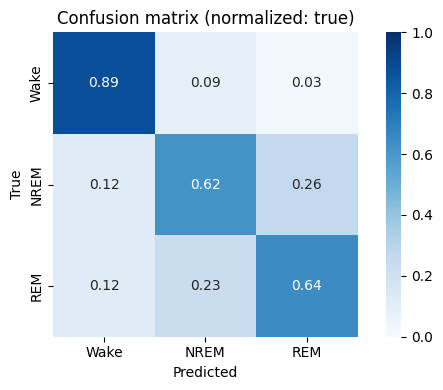

MEDIAN SMOOTHED PREDICTIONS (~20s)

              precision    recall  f1-score   support

        NREM      0.843     0.680     0.753     36635
         REM      0.319     0.633     0.425      5726
        Wake      0.858     0.894     0.876     35249

    accuracy                          0.774     77610
   macro avg      0.674     0.736     0.684     77610
weighted avg      0.811     0.774     0.784     77610



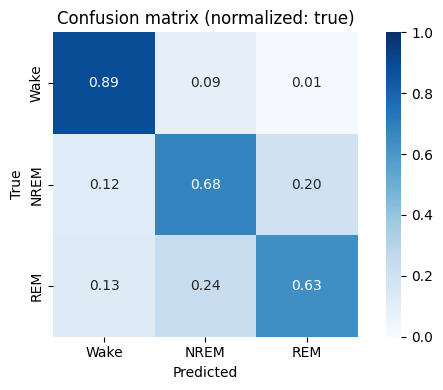

MEDIAN + MIN BOUT SMOOTHED PREDICTIONS (~20s)

              precision    recall  f1-score   support

        NREM      0.845     0.682     0.755     36635
         REM      0.321     0.632     0.425      5726
        Wake      0.858     0.896     0.876     35249

    accuracy                          0.775     77610
   macro avg      0.675     0.736     0.686     77610
weighted avg      0.812     0.775     0.786     77610



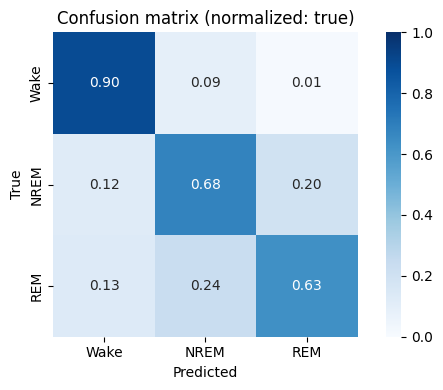

In [367]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced"))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print(f'RAW PREDICTIONS\n')
print(classification_report(y_val, y_pred, digits=3))
plot_confusion_matrix(y_val, y_pred, labels=CLASS_ORDER, normalize='true')

y_pred_med20 = smooth_median(y_pred, kernel=5)  # ~20s
print(f'MEDIAN SMOOTHED PREDICTIONS (~20s)\n')
print(classification_report(y_val, y_pred_med20, digits=3))
plot_confusion_matrix(y_val, y_pred_med20, labels=CLASS_ORDER, normalize="true")

y_pred_smooth  = smooth_min_bout(y_pred_med20, min_len={"REM":2, "NREM":2, "Wake":2})
print(f'MEDIAN + MIN BOUT SMOOTHED PREDICTIONS (~20s)\n')
print(classification_report(y_val, y_pred_smooth, digits=3))
plot_confusion_matrix(y_val, y_pred_smooth, labels=CLASS_ORDER, normalize="true")

animals: train=13, val=5, test=4


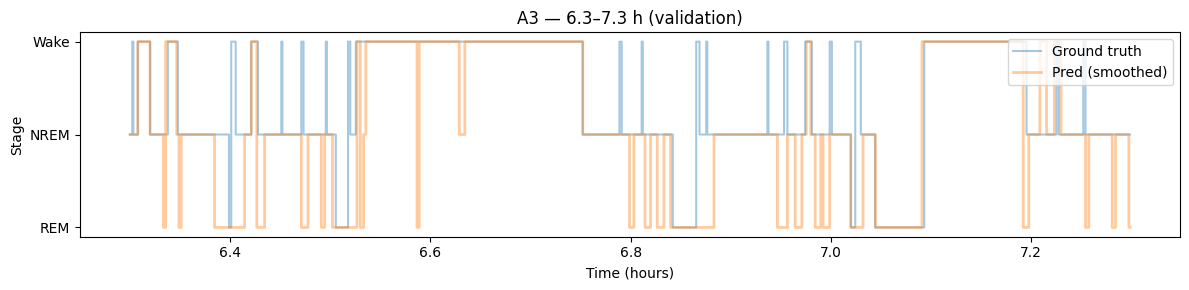

In [368]:
# Get animals per split
train_animals, val_animals, test_animals = animals_by_split(groups, train_idx, val_idx, test_idx)

# pick one from validation (or use test_animals)
animal = sorted(val_animals)[0]              # or: np.random.choice(sorted(val_animals))
assert animal not in train_animals           # double-check

# Now subset the 1-hour window and plot
start_h   = 6.3
duration_h= 1.0

X_win, y_true_win, t_s_win, idx_win = subset_window(
    df, animal, feature_cols, start_h=start_h, duration_h=duration_h
)

# Predict (no leakage: animal is from val/test only)
y_pred_win = pipe.predict(X_win)

# Smooth (optional)
y_pred_med20   = smooth_median(y_pred_win, kernel=5)  # ~20 s
y_pred_smooth  = smooth_min_bout(y_pred_med20, min_len={"REM":2, "NREM":2, "Wake":2})

# Plot
plot_hypnogram(
    t_s_win,
    y_true=y_true_win,
    y_pred=None,
    y_pred_smooth=y_pred_smooth,
    title=f"{animal} — {start_h:.1f}–{start_h + duration_h:.1f} h (validation)"
)

### 5.2 XGBoost

XGB (early stopping) — validation
              precision    recall  f1-score   support

        NREM      0.879     0.767     0.819     36635
         REM      0.489     0.602     0.540      5726
        Wake      0.832     0.911     0.870     35249

    accuracy                          0.820     77610
   macro avg      0.733     0.760     0.743     77610
weighted avg      0.829     0.820     0.821     77610



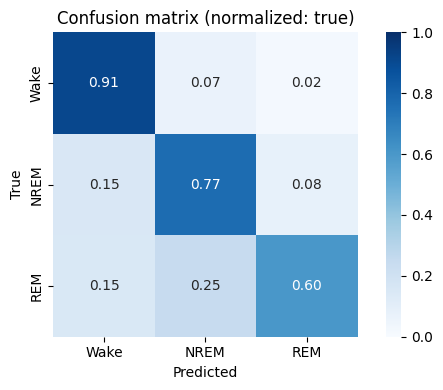

MEDIAN SMOOTHED PREDICTIONS (~20s)

              precision    recall  f1-score   support

        NREM      0.876     0.815     0.845     36635
         REM      0.690     0.586     0.634      5726
        Wake      0.834     0.914     0.872     35249

    accuracy                          0.843     77610
   macro avg      0.800     0.772     0.784     77610
weighted avg      0.843     0.843     0.842     77610



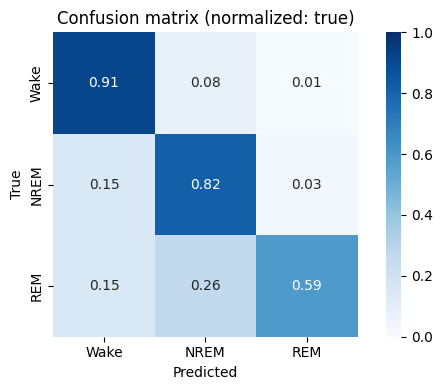

MEDIAN + MIN BOUT SMOOTHED PREDICTIONS (~20s)

              precision    recall  f1-score   support

        NREM      0.877     0.821     0.848     36635
         REM      0.724     0.583     0.646      5726
        Wake      0.834     0.916     0.873     35249

    accuracy                          0.846     77610
   macro avg      0.812     0.773     0.789     77610
weighted avg      0.846     0.846     0.844     77610



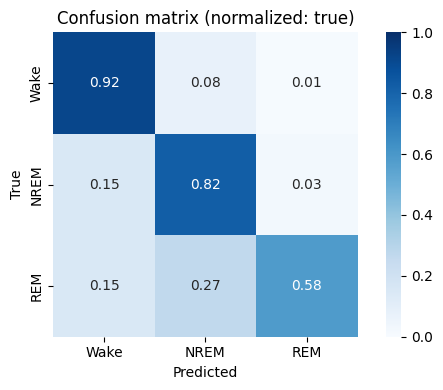

In [369]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

# Encode labels
le = LabelEncoder()
y_tr_enc   = le.fit_transform(y_train)
y_val_enc  = le.transform(y_val)
y_test_enc = le.transform(y_test)

# Class-balanced sample weights (boost REM)
classes = np.unique(y_train)
w_map = dict(zip(classes, compute_class_weight("balanced", classes=classes, y=y_train)))
sw_train = np.array([w_map[c] for c in y_train])
sw_val   = np.array([w_map[c] for c in y_val])  # optional if your XGB version supports eval weights

# Build model (note: early_stopping_rounds set on the estimator, not in fit)
clf = XGBClassifier(
    objective="multi:softprob",
    num_class=len(le.classes_),      # harmless; XGB can infer but this is explicit
    n_estimators=3000,               # high cap; early stopping will trim
    learning_rate=0.07,              # << not 0.001
    max_depth=4,
    min_child_weight=1.0,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    reg_alpha=0.0,
    tree_method="hist",              # use "gpu_hist" if you have a GPU
    eval_metric="mlogloss",
    early_stopping_rounds=100,       # <-- moved here
    random_state=42,
)

# Fit
fit_kwargs = dict(eval_set=[(X_val, y_val_enc)], verbose=False)
clf.fit(X_train, y_tr_enc, sample_weight=sw_train, sample_weight_eval_set=[sw_val], **fit_kwargs)

# Evaluate on validation animals
y_pred_enc = clf.predict(X_val)
y_pred = le.inverse_transform(y_pred_enc)

print("XGB (early stopping) — validation")
print(classification_report(y_val, y_pred, digits=3))
plot_confusion_matrix(y_val, y_pred, labels=CLASS_ORDER, normalize="true")

y_pred_med20 = smooth_median(y_pred, kernel=5)  # ~20s
print(f'MEDIAN SMOOTHED PREDICTIONS (~20s)\n')
print(classification_report(y_val, y_pred_med20, digits=3))
plot_confusion_matrix(y_val, y_pred_med20, labels=CLASS_ORDER, normalize="true")

y_pred_smooth  = smooth_min_bout(y_pred_med20, min_len={"REM":3, "NREM":2, "Wake":2})
print(f'MEDIAN + MIN BOUT SMOOTHED PREDICTIONS (~20s)\n')
print(classification_report(y_val, y_pred_smooth, digits=3))
plot_confusion_matrix(y_val, y_pred_smooth, labels=CLASS_ORDER, normalize="true")

## 6. Performance on test set

### 6.1 Logistic Regression


TEST SET (held-out animals)

-- Raw predictions --
Accuracy: 0.812
              precision    recall  f1-score   support

        NREM      0.901     0.844     0.872     38709
         REM      0.459     0.873     0.601      6379
        Wake      0.889     0.718     0.794     17191

    accuracy                          0.812     62279
   macro avg      0.750     0.812     0.756     62279
weighted avg      0.853     0.812     0.823     62279



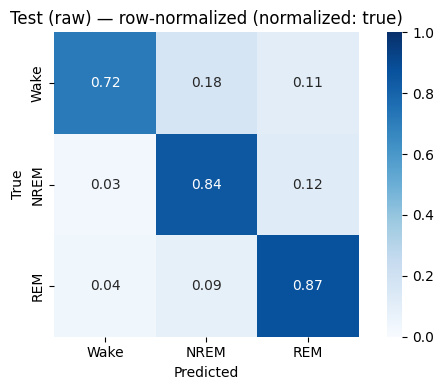


-- Median smoothing (k=5 ≈ 20s) --
Accuracy: 0.861
              precision    recall  f1-score   support

        NREM      0.888     0.924     0.906     38709
         REM      0.645     0.915     0.757      6379
        Wake      0.932     0.700     0.799     17191

    accuracy                          0.861     62279
   macro avg      0.821     0.846     0.820     62279
weighted avg      0.875     0.861     0.861     62279



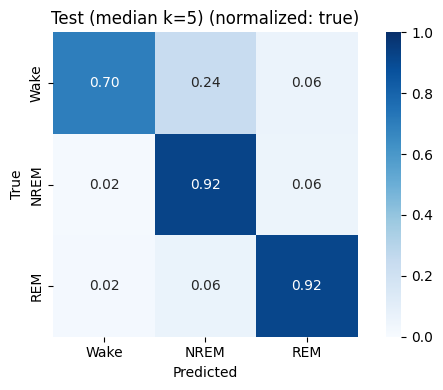


-- Median + minimum-bout smoothing --
Accuracy: 0.867
              precision    recall  f1-score   support

        NREM      0.887     0.933     0.909     38709
         REM      0.676     0.913     0.777      6379
        Wake      0.931     0.702     0.800     17191

    accuracy                          0.867     62279
   macro avg      0.831     0.849     0.829     62279
weighted avg      0.878     0.867     0.866     62279



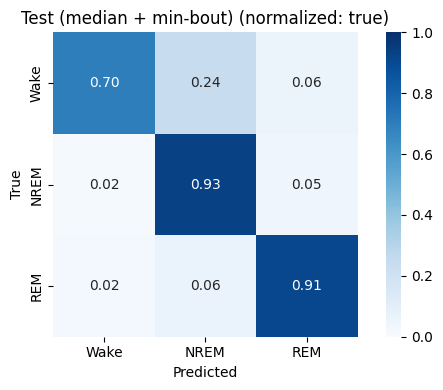

In [370]:
# ---------- TEST EVALUATION ----------
print("\n==============================")
print("TEST SET (held-out animals)")
print("==============================")

# Raw predictions
y_pred_test = pipe.predict(X_test)

print("\n-- Raw predictions --")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.3f}")
print(classification_report(y_test, y_pred_test, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_pred_test, labels=CLASS_ORDER,
                          normalize="true", title="Test (raw) — row-normalized")

# Median smoothing (~20 s if 4 s epochs & kernel=5)
y_pred_test_med = smooth_median(y_pred_test, kernel=5)
print("\n-- Median smoothing (k=5 ≈ 20s) --")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test_med):.3f}")
print(classification_report(y_test, y_pred_test_med, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_pred_test_med, labels=CLASS_ORDER,
                          normalize="true", title="Test (median k=5)")

# Median + minimum-bout smoothing
min_bouts = {"REM": 3, "NREM": 2, "Wake": 2}  # in epochs (3*4s=12s for REM)
y_pred_test_smooth = smooth_min_bout(y_pred_test_med, min_len=min_bouts)
print("\n-- Median + minimum-bout smoothing --")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test_smooth):.3f}")
print(classification_report(y_test, y_pred_test_smooth, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_pred_test_smooth, labels=CLASS_ORDER,
                          normalize="true", title="Test (median + min-bout)")

animals: train=13, val=5, test=4


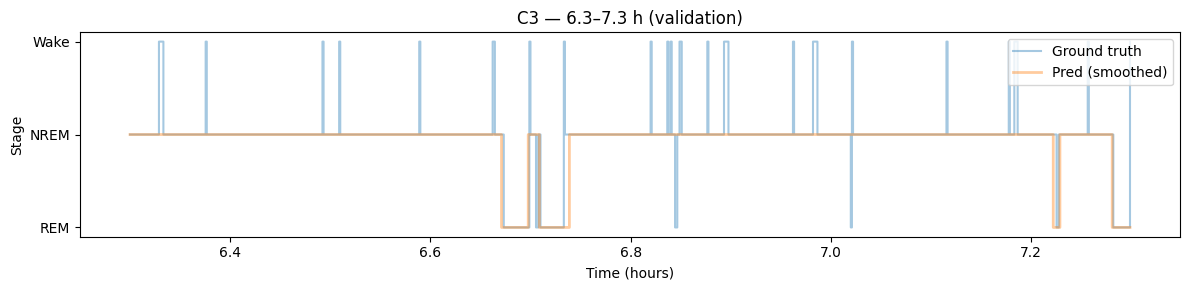

In [371]:
# Get animals per split
train_animals, val_animals, test_animals = animals_by_split(groups, train_idx, val_idx, test_idx)

# pick one from validation (or use test_animals)
animal = sorted(test_animals)[0]              # or: np.random.choice(sorted(val_animals))
assert animal not in train_animals           # double-check

# Now subset the 1-hour window and plot
start_h   = 6.3
duration_h= 1.0

X_win, y_true_win, t_s_win, idx_win = subset_window(
    df, animal, feature_cols, start_h=start_h, duration_h=duration_h
)

# Predict (no leakage: animal is from val/test only)
y_pred_win = pipe.predict(X_win)

# Smooth (optional)
y_pred_med20   = smooth_median(y_pred_win, kernel=5)  # ~20 s
y_pred_smooth  = smooth_min_bout(y_pred_med20, min_len={"REM":3, "NREM":2, "Wake":2})

# Plot
plot_hypnogram(
    t_s_win,
    y_true=y_true_win,
    y_pred=None,
    y_pred_smooth=y_pred_smooth,
    title=f"{animal} — {start_h:.1f}–{start_h + duration_h:.1f} h (validation)"
)

### 6.2 XGBoost


TEST SET (held-out animals)

-- Raw predictions --
Accuracy: 0.841
              precision    recall  f1-score   support

        NREM      0.963     0.833     0.893     38709
         REM      0.511     0.820     0.630      6379
        Wake      0.804     0.869     0.835     17191

    accuracy                          0.841     62279
   macro avg      0.759     0.841     0.786     62279
weighted avg      0.873     0.841     0.850     62279



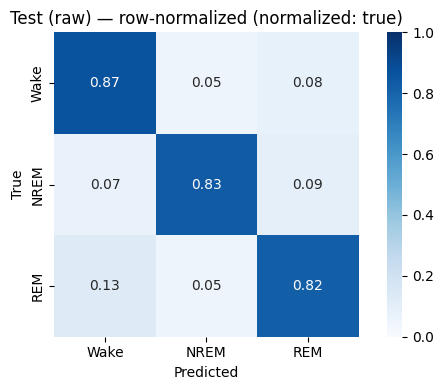


-- Median smoothing (k=5 ≈ 20s) --
Accuracy: 0.891
              precision    recall  f1-score   support

        NREM      0.943     0.911     0.927     38709
         REM      0.704     0.856     0.773      6379
        Wake      0.862     0.857     0.860     17191

    accuracy                          0.891     62279
   macro avg      0.836     0.875     0.853     62279
weighted avg      0.896     0.891     0.893     62279



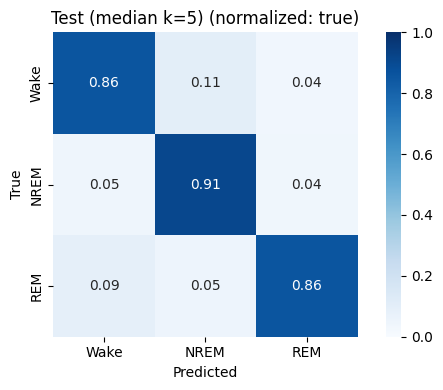


-- Median + minimum-bout smoothing --
Accuracy: 0.895
              precision    recall  f1-score   support

        NREM      0.942     0.918     0.930     38709
         REM      0.733     0.854     0.789      6379
        Wake      0.862     0.860     0.861     17191

    accuracy                          0.895     62279
   macro avg      0.846     0.877     0.860     62279
weighted avg      0.899     0.895     0.896     62279



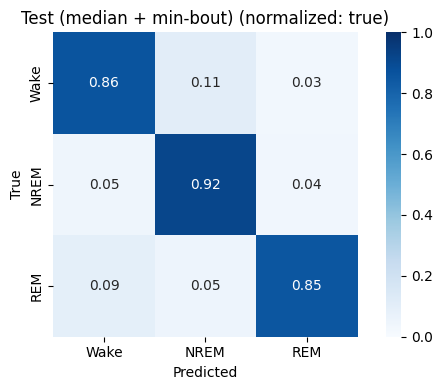

In [372]:
# ---------- TEST EVALUATION ----------
print("\n==============================")
print("TEST SET (held-out animals)")
print("==============================")

# Raw predictions
y_pred_test_enc = clf.predict(X_test)
y_pred_test = le.inverse_transform(y_pred_test_enc)

print("\n-- Raw predictions --")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.3f}")
print(classification_report(y_test, y_pred_test, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_pred_test, labels=CLASS_ORDER,
                          normalize="true", title="Test (raw) — row-normalized")

# Median smoothing (~20 s if 4 s epochs & kernel=5)
y_pred_test_med = smooth_median(y_pred_test, kernel=5)
print("\n-- Median smoothing (k=5 ≈ 20s) --")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test_med):.3f}")
print(classification_report(y_test, y_pred_test_med, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_pred_test_med, labels=CLASS_ORDER,
                          normalize="true", title="Test (median k=5)")

# Median + minimum-bout smoothing
min_bouts = {"REM": 3, "NREM": 2, "Wake": 2}  # in epochs (3*4s=12s for REM)
y_pred_test_smooth = smooth_min_bout(y_pred_test_med, min_len=min_bouts)
print("\n-- Median + minimum-bout smoothing --")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test_smooth):.3f}")
print(classification_report(y_test, y_pred_test_smooth, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_pred_test_smooth, labels=CLASS_ORDER,
                          normalize="true", title="Test (median + min-bout)")


animals: train=13, val=5, test=4


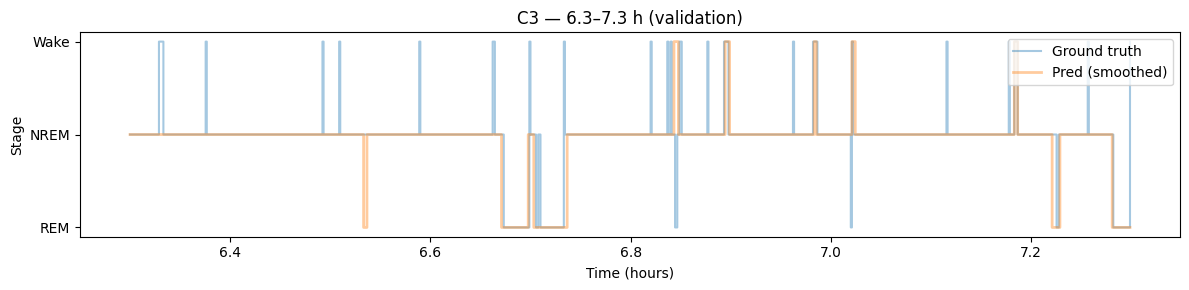

In [373]:
# Get animals per split
train_animals, val_animals, test_animals = animals_by_split(groups, train_idx, val_idx, test_idx)

# pick one from validation (or use test_animals)
animal = sorted(test_animals)[0]              # or: np.random.choice(sorted(val_animals))
assert animal not in train_animals           # double-check

# Now subset the 1-hour window and plot
start_h   = 6.3
duration_h= 1.0

X_win, y_true_win, t_s_win, idx_win = subset_window(
    df, animal, feature_cols, start_h=start_h, duration_h=duration_h
)

# Predict (no leakage: animal is from val/test only)
y_pred_win = clf.predict(X_win)
y_pred_win = le.inverse_transform(y_pred_win)

# Smooth (optional)
y_pred_med20   = smooth_median(y_pred_win, kernel=5)  # ~20 s
y_pred_smooth  = smooth_min_bout(y_pred_med20, min_len={"REM":3, "NREM":2, "Wake":2})

# Plot
plot_hypnogram(
    t_s_win,
    y_true=y_true_win,
    y_pred=None,
    y_pred_smooth=y_pred_smooth,
    title=f"{animal} — {start_h:.1f}–{start_h + duration_h:.1f} h (validation)"
)

In [358]:
def animals_by_split(groups, train_idx, val_idx, test_idx):
    g = np.asarray(groups)
    tr, va, te = set(g[train_idx]), set(g[val_idx]), set(g[test_idx])
    assert tr.isdisjoint(va) and tr.isdisjoint(te) and va.isdisjoint(te)
    print(f"animals: train={len(tr)}, val={len(va)}, test={len(te)}")
    return tr, va, te

train_animals, val_animals, test_animals = animals_by_split(groups, train_idx, val_idx, test_idx)

animals: train=13, val=5, test=4


In [359]:
from collections import Counter

def class_balance(y, idx, name):
    c = Counter(y[idx])
    tot = len(idx)
    print(f"[{name}] n={tot}  " + ", ".join(f"{k}={c.get(k,0)} ({c.get(k,0)/tot:.1%})" for k in ["Wake","NREM","REM"]))

class_balance(y, train_idx, "train")
class_balance(y, val_idx,   "val")
class_balance(y, test_idx,  "test")


[train] n=190337  Wake=67835 (35.6%), NREM=105263 (55.3%), REM=17239 (9.1%)
[val] n=92325  Wake=36143 (39.1%), NREM=48924 (53.0%), REM=7258 (7.9%)
[test] n=61177  Wake=21361 (34.9%), NREM=33588 (54.9%), REM=6228 (10.2%)


In [360]:
def cohorts_in_split(df, idx, name):
    print(f"\n[{name}] cohorts:")
    print(df.iloc[idx].groupby("cohort").size().sort_values(ascending=False))

cohorts_in_split(df, train_idx, "train")
cohorts_in_split(df, val_idx,   "val")
cohorts_in_split(df, test_idx,  "test")


[train] cohorts:
cohort
CohortD    64795
CohortC    52229
CohortB    49700
CohortA    23613
dtype: int64

[val] cohorts:
cohort
CohortD    64769
CohortC    27556
dtype: int64

[test] cohorts:
cohort
CohortA    33985
CohortC    27192
dtype: int64
